# *Monod* demonstration: analysis of normalization procedures

We have run the *Monod* inference pipeline on seven pre-clustered mouse brain cell glutamatergic subtypes, as well as the entire glutamatergic cell type. In this notebook, we analyze whether the amount of biological variation between the subtypes concords with the amount of biological variation predicted by normalization and mechanistic fit procedures.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()


In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [3]:
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dir_string = './fits/gg_230328_026_allen_celltypes_1'


# Normalization analysis

In [5]:
sd_string = dir_string+'/allen_B08_Glutamatergic/raw.sd'

In [6]:
sd = monod.analysis.load_search_data(sd_string)

In [7]:
#a e s t h e t i c s
fs = 16

In [8]:
from scipy import stats
import copy

Compute the normalization-based CV$^2$ fractions. Note that there are built-in functions for this functionality in *Monod* under `get_noise_decomp`, but for transparency, we do the computations by hand.

In [9]:
S = copy.deepcopy(sd.layers[1])

In [10]:
C_S = S.sum(0).mean()
S_PF = S/(S.sum(0)[None,:])*C_S
S_log = np.log(S_PF+1)

In [11]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
pca_transformer.fit(S_log.T)
S_PCA_50D = pca_transformer.transform(S_log.T).T
S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [12]:
#this is by far the slowest part.
import umap
umap_transformer = umap.UMAP()
umap_transformer.fit(S_PCA_50D.T)
S_UMAP_2D = umap_transformer.transform(S_PCA_50D.T).T
S_UMAP_50D = umap_transformer.inverse_transform(S_UMAP_2D.T).T
S_UMAP = pca_transformer.inverse_transform(S_UMAP_50D.T).T

Compute the baseline.

In [13]:
dataset_meta = ['B08']
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 
sd_strings = [dir_string + '/' + x + '/raw.sd' for x in dataset_names]

In [14]:
sd_arr = [monod.analysis.load_search_data(x) for x in sd_strings]

In [15]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
pi = n_cells / np.sum(n_cells)

In [16]:
total_mean = S.mean(1)
total_variance = S.var(1)

In [17]:
subtype_means = np.asarray([x.layers[1].mean(1) for x in sd_arr]).T

In [18]:
baseline = (((subtype_means-total_mean[:,None])**2) * pi[None,:]).sum(1) / total_variance

In [19]:
q = np.quantile(total_mean,0.95)
gf = total_mean<q

In [20]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF = S_PF.var(1)/S_PF.mean(1)**2
cv2_log = S_log.var(1)/S_log.mean(1)**2
cv2_PCA = S_PCA.var(1)/S_PCA.mean(1)**2
cv2_UMAP = S_UMAP.var(1)/S_UMAP.mean(1)**2

In [21]:
cv2s = np.asarray([cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP])

Text(0.5, 1.0, 'CV2')

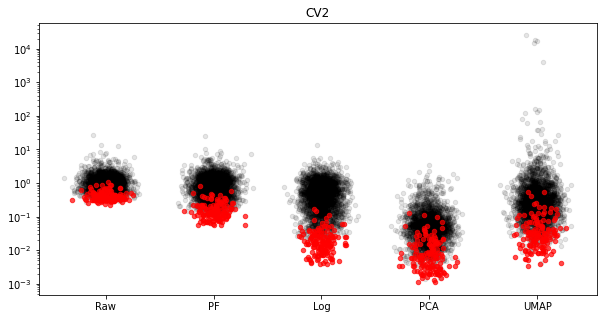

In [22]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2s[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2s[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'])
ax1.set_title('CV2')


In [23]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF_frac = cv2_PF / cv2_raw
cv2_log_frac = cv2_log / cv2_raw
cv2_PCA_frac = cv2_PCA / cv2_raw
cv2_UMAP_frac = cv2_UMAP / cv2_raw

In [24]:
cv2_fracs = np.asarray([cv2_PF_frac,cv2_log_frac,cv2_PCA_frac,cv2_UMAP_frac])

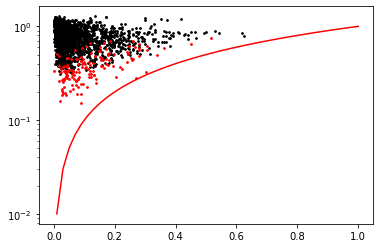

In [25]:
plt.scatter(baseline[gf],cv2_PF_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PF_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

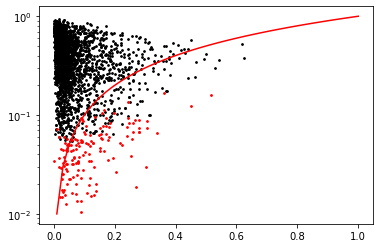

In [26]:
plt.scatter(baseline[gf],cv2_log_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_log_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

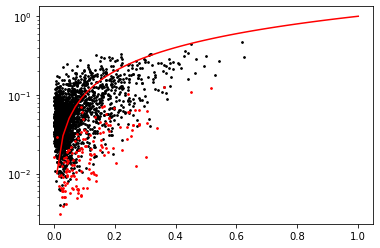

In [27]:
plt.scatter(baseline[gf],cv2_PCA_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PCA_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

(-0.1, 2.0)

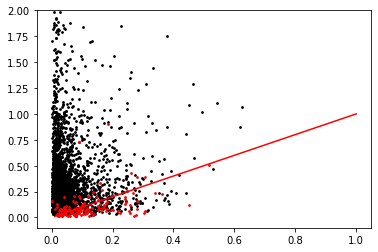

In [28]:
plt.scatter(baseline[gf],cv2_UMAP_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_UMAP_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,2])

# Monod

In [29]:
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
# cluster_names = ['Glutamatergic','GABAergic']
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
n_datasets = len(dataset_names)

In [30]:
# dir_string = './fits/gg_220913_024_allen_celltypes_2'
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [31]:
opt = []
n_cells = []
sr_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    opt.append(sr.samp_optimum)
    n_cells.append(sr.n_cells)
    sr_arr.append(sr)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [32]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

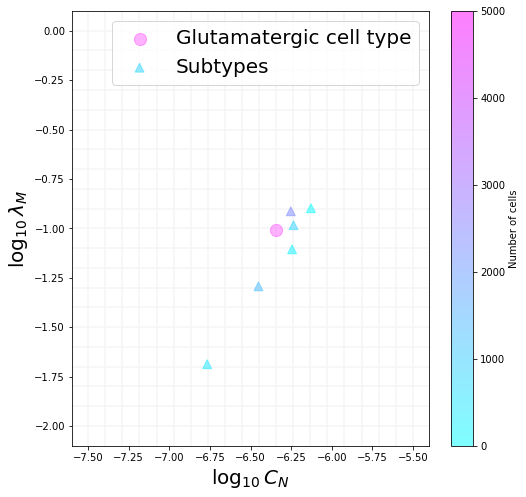

In [33]:
fs = 20

d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.01
opt_ = opt+jit
cmap = 'cool'

ctf = range(6,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],150,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='Glutamatergic cell type',vmin=0,vmax=5000)
stf = range(6)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='Subtypes',vmin=0,vmax=5000)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = './figs/landscape_qc_allen.png'
plt.savefig(fig_string,dpi=450)


In [34]:
model_moments = []
li = sr_arr[-1].samp_optimum_ind
for j in range(n_datasets-1):

    p = 10**sr_arr[j].param_estimates[li] #b, beta, gamma
    l = 10**sr_arr[j].regressor[li]
    
    p=p.T
    l=l.T
    mu_bio =  p[0]/p[2]
    mu_tech = mu_bio * l[1]
    var_bio = mu_bio*(1+p[0]*p[1]/(p[1]+p[2]))
    var_tech = mu_tech*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
    model_moments.append((mu_bio,mu_tech,var_bio,var_tech))
    
model_moments = np.asarray(model_moments)


In [35]:
mean_bio = (model_moments[:,0,:]*pi[:,None]).sum(0)
var_bio = (model_moments[:,2,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,0,:]-mean_bio)**2)*pi[:,None]).sum(0)

mean_tech = (model_moments[:,1,:]*pi[:,None]).sum(0)
var_tech = (model_moments[:,3,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,1,:]-mean_tech)**2)*pi[:,None]).sum(0)

cv2_bio = var_bio/mean_bio**2
cv2_tech = var_tech/mean_tech**2
cv2_monod_frac = cv2_bio/cv2_tech


(-0.1, 1.0)

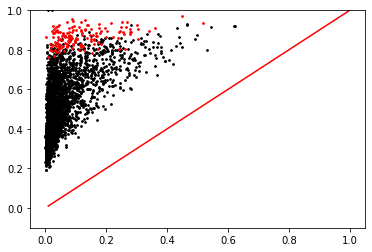

In [36]:
plt.scatter(baseline[gf],cv2_monod_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_monod_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,1])

# Figures

## Fig 2 b-h

In [37]:
# a e s t h e t i c s
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 20
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'

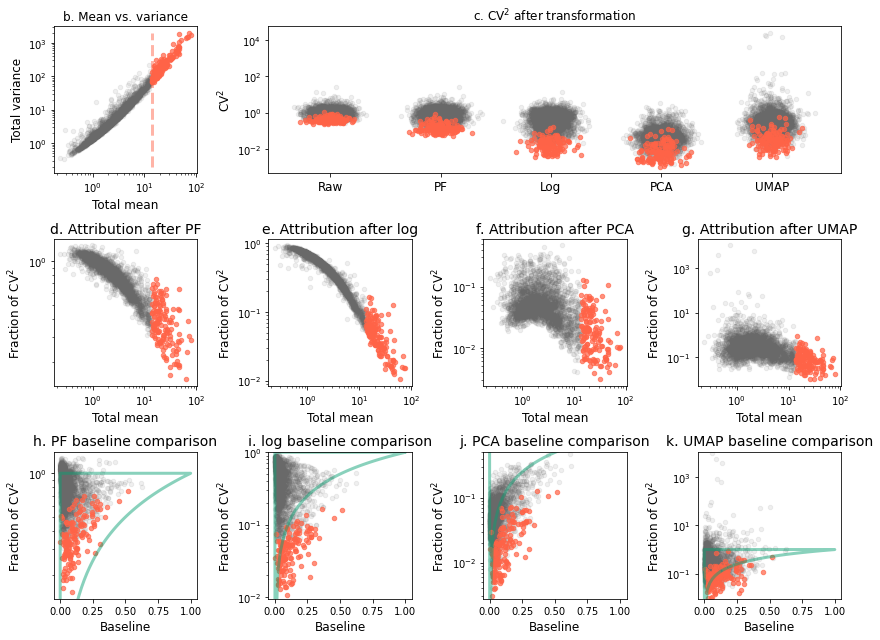

In [38]:
fig1,ax1=plt.subplots(3,4,figsize=(12,9))

fl = 97+1
#mean-variance relationship
ax1[0,0].scatter(total_mean[gf],total_variance[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0,0].scatter(total_mean[~gf],total_variance[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0,0].plot([q]*2,[2e-1,2e3],'--',color=c_highlight,alpha=alpha_line,linewidth=lw)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0,0].set_ylabel('Total variance',fontsize=fs_axes)
ax1[0,0].set_title('{}. Mean vs. variance'.format(chr(fl)))

#cv2
gs = ax1[0,1].get_gridspec()
for ax in ax1[0,1:]:
    ax.remove()
axcv2 = fig1.add_subplot(gs[0,1:])
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    axcv2.scatter(xlocs[gf],cv2s[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    axcv2.scatter(xlocs[~gf],cv2s[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
axcv2.set_yscale('log')
axcv2.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'],fontsize=fs_axes)
axcv2.set_ylabel(r'CV$^2$',fontsize=fs_axes)
axcv2.set_title('{}. CV$^2$ after transformation'.format(chr(fl+1)))

#mean dependence
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(total_mean[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(total_mean[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    ax1[1,k].set_xscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_xlabel('Total mean',fontsize=fs_axes)
    ax1[1,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    ax1[1,k].set_title('{}. Attribution after {}'.format(chr(fl+2+k),names[k]),fontsize=fs_title)

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[2,k].scatter(baseline[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[2,k].scatter(baseline[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    ax1[2,k].set_yscale('log')
    ax1[2,k].set_xlabel('Baseline',fontsize=fs_axes)
    ax1[2,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[2,k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[2,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[2,k].set_xticks(np.linspace(0,1,5))
    ax1[2,k].set_title('{}. {} baseline comparison'.format(chr(fl+6+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig2b_k.png',dpi=450)
fig1.savefig('./figs/fig2b_k.pdf')


### Supplement to Fig. 2

0.0
0.08166723144696712
0.35174517112843107
0.3537783802100983


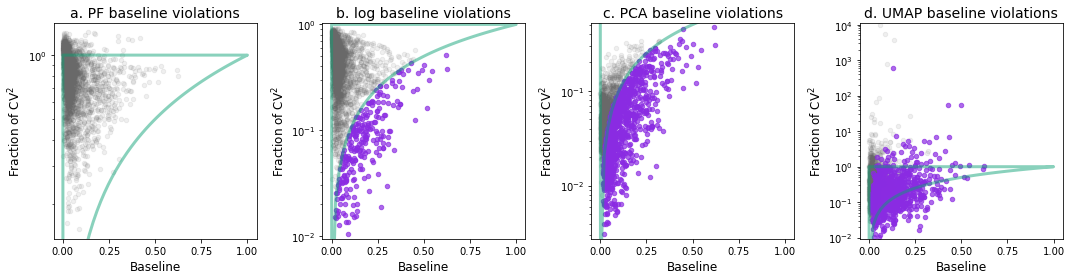

In [39]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    if k==0:
        gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    else:
        gf_ = gf_|(cv2_fracs[k]<baseline)
    print(gf_.sum()/len(gf_))
    ax1[k].scatter(baseline[~gf_],cv2_fracs[k][~gf_],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(baseline[gf_],cv2_fracs[k][gf_],ms_highlight,c_baseline_violation,alpha=alpha_highlight)
    ax1[k].set_yscale('log')
    ax1[k].set_xlabel('Baseline',fontsize=fs_axes)
    ax1[k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xticks(np.linspace(0,1,5))
    ax1[k].set_title('{}. {} baseline violations'.format(chr(97+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/baseline_violation.png',dpi=450)
fig1.savefig('./figs/baseline_violation.pdf')


# Fig 3 

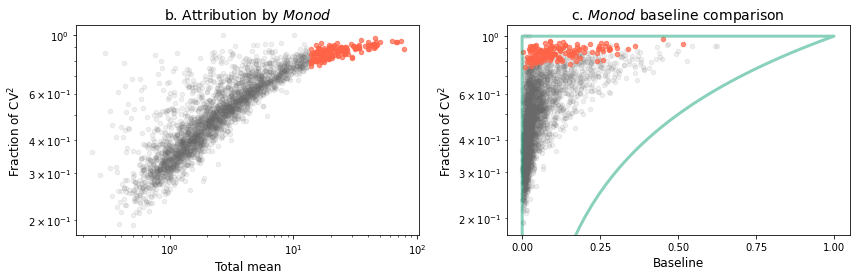

In [40]:
fig1,ax1=plt.subplots(1,2,figsize=(12,4))

# #mean dependence
ax1[0].scatter(total_mean[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0].scatter(total_mean[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1[0].set_title('{}. '.format(chr(97+1))+r'Attribution by $\it{Monod}$',fontsize=fs_title)


ax1[1].scatter(baseline[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[1].scatter(baseline[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Baseline',fontsize=fs_axes)
ax1[1].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1[1].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1[1].set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1[1].set_xticks(np.linspace(0,1,5))
ax1[1].set_title('{}. '.format(chr(97+2))+r'$\it{Monod}$ baseline comparison',fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig3bc.png',dpi=450)
fig1.savefig('./figs/fig3bc.pdf')


## Supplements to Fig. 3

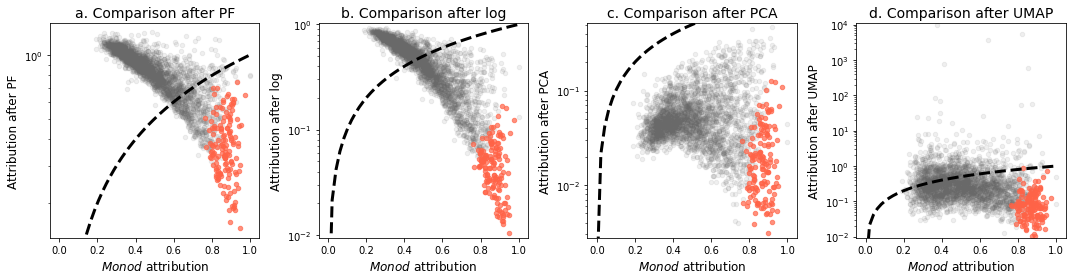

In [41]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[k].scatter(cv2_monod_frac[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(cv2_monod_frac[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[k].set_yscale('log')
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[k].set_title('{}. Comparison after {}'.format(chr(97+k),names[k]),fontsize=fs_title)
fig1.tight_layout()
fig1.savefig('./figs/monod_norm_comparison.png',dpi=450)
fig1.savefig('./figs/monod_norm_comparison.pdf')


What if we fit the entire dataset using *Monod*?

In [42]:
# model_moments = []
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[-1].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[-1].regressor[li]

p=p.T
l=l.T
mu_bio_glu =  p[0]/p[2]
mu_tech_glu = mu_bio_glu * l[1]
var_bio_glu = mu_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
var_tech_glu = mu_tech_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
cv2_bio_glu = var_bio_glu/mu_bio_glu**2
cv2_tech_glu = var_tech_glu/mu_tech_glu**2
cv2_monod_frac_glu = cv2_bio_glu/cv2_tech_glu


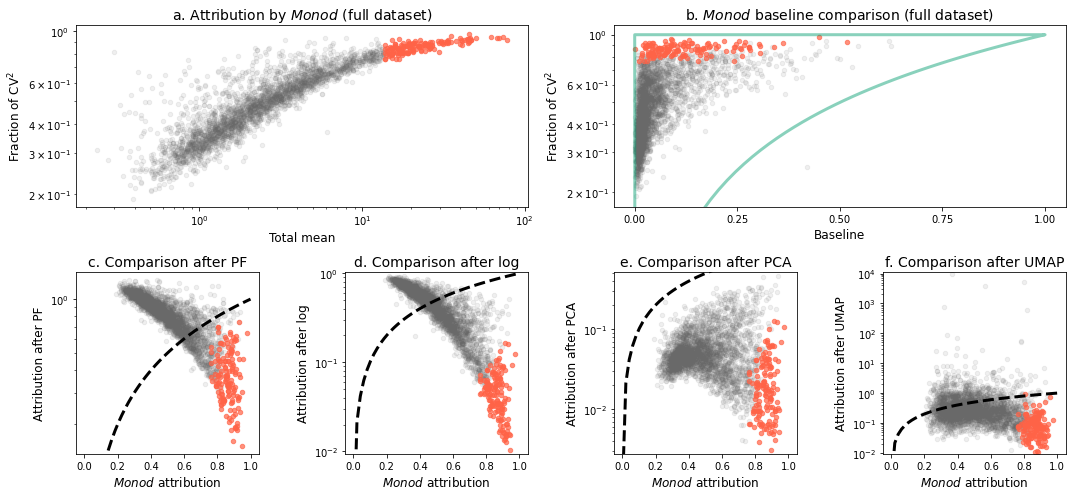

In [43]:
# fig1,ax1=plt.subplots(1,2,figsize=(12,6))
fig1,ax1=plt.subplots(2,4,figsize=(15,7))


gs = ax1[0,0].get_gridspec()
for ax in ax1[0,0:2]:
    ax.remove()
ax1_a = fig1.add_subplot(gs[0,0:2])
ax1_a.scatter(total_mean[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_a.scatter(total_mean[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_a.set_xscale('log')
ax1_a.set_yscale('log')
ax1_a.set_xlabel('Total mean',fontsize=fs_axes)
ax1_a.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1_a.set_title('{}. '.format(chr(97))+r'Attribution by $\it{Monod}$ (full dataset)',fontsize=fs_title)

gs = ax1[0,2].get_gridspec()
for ax in ax1[0,2:]:
    ax.remove()
ax1_b = fig1.add_subplot(gs[0,2:])
ax1_b.scatter(baseline[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_b.scatter(baseline[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_b.set_yscale('log')
ax1_b.set_xlabel('Baseline',fontsize=fs_axes)
ax1_b.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1_b.plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1_b.set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1_b.set_xticks(np.linspace(0,1,5))
ax1_b.set_title('{}. '.format(chr(97+1))+r'$\it{Monod}$ baseline comparison (full dataset)',fontsize=fs_title)

names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(cv2_monod_frac_glu[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(cv2_monod_frac_glu[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[1,k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[1,k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[1,k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[1,k].set_title('{}. Comparison after {}'.format(chr(97+k+2),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/monod_glu.png',dpi=450)
fig1.savefig('./figs/monod_glu.pdf')
